In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

### 1. Import and Data Preparation
Load the cleaned dataset

In [2]:
data_path = "../data/"
trips_clean_path = os.path.join(data_path, "Trips_2018_clean.csv")

data = pd.read_csv(trips_clean_path)
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


Extract unique station coordinates, and scale them for Mean Shift.

In [3]:
# Combine start and end stations
start_stations = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
end_stations   = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']]

# Rename columns so they match
end_stations = end_stations.rename(columns={
    'end_station_id': 'station_id',
    'end_station_latitude': 'lat',
    'end_station_longitude': 'lon'
})

start_stations = start_stations.rename(columns={
    'start_station_id': 'station_id',
    'start_station_latitude': 'lat',
    'start_station_longitude': 'lon'
})

# Concatenate and keep unique
stations = pd.concat([start_stations, end_stations], ignore_index=True).drop_duplicates()

# Extract coords
coords = stations[['lat', 'lon']]

# Scale them
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

stations.head()

,station_id,lat,lon
0,72.0,40.767272,-73.993929
1324,79.0,40.719116,-74.006667
2430,82.0,40.711174,-74.000165
2865,83.0,40.683826,-73.976323
3548,119.0,40.696089,-73.978034


### Initial Bandwidth Exploration (Coarse Search)

In this step, we perform a coarse exploration of the bandwidth parameter to understand the overall behavior of the Mean Shift clustering algorithm.  
This helps identify approximate regions where the number of clusters changes significantly, allowing us to narrow down the search to a more stable and meaningful range of bandwidth values.

In [4]:
bandwidth_values = [0.2, 0.3, 0.4, 0.5, 0.6]

print("Testing manual bandwidths...\n")

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))
    print(f"Bandwidth: {b}, Clusters: {n_clusters}")

Testing manual bandwidths...

Bandwidth: 0.2, Clusters: 83
Bandwidth: 0.3, Clusters: 40
Bandwidth: 0.4, Clusters: 23
Bandwidth: 0.5, Clusters: 13
Bandwidth: 0.6, Clusters: 9


### Refined Bandwidth Search (Fine-Grained Stability Analysis)

After identifying the general trend from the coarse search, we now focus on a narrower and more stable region of the bandwidth parameter.  
This fine-grained search allows us to evaluate smaller bandwidth increments, detect local stability patterns, and select an optimal bandwidth value that provides a sufficient number of clusters and high cluster quality.

In [5]:
from scipy.interpolate import make_interp_spline

bandwidth_values = np.round(np.linspace(0.20, 0.45, 40), 3) 
cluster_counts = []

for b in bandwidth_values:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    cluster_counts.append(len(np.unique(labels)))

cluster_counts = np.array(cluster_counts)

delta = np.abs(np.diff(cluster_counts, prepend=cluster_counts[0]))

x_smooth = np.linspace(bandwidth_values.min(), bandwidth_values.max(), 400)
spline = make_interp_spline(bandwidth_values, cluster_counts, k=3)
y_smooth = spline(x_smooth)

### Bandwidth Stability Visualization — Note

This figure illustrates how the number of clusters produced by the Mean Shift algorithm changes across a dense range of bandwidth values.  
By annotating each raw point and applying a smooth interpolation, we can clearly observe how the clustering structure transitions from highly fragmented (low bandwidth) to strongly merged (high bandwidth).

A distinct stability plateau emerges in the range **0.36–0.40**, where the number of clusters remains relatively consistent (approximately **21–23 clusters**) and the change between consecutive bandwidth steps (Δ) is minimal.  
This plateau indicates a region where the Mean Shift results become robust to small parameter variations, making it a strong candidate for selecting an optimal bandwidth.

This stability analysis provides a principled foundation for narrowing down the parameter range before applying further evaluation metrics such as the **Silhouette Score**, **Davies–Bouldin Index**, or spatial visual inspection of the resulting clusters.

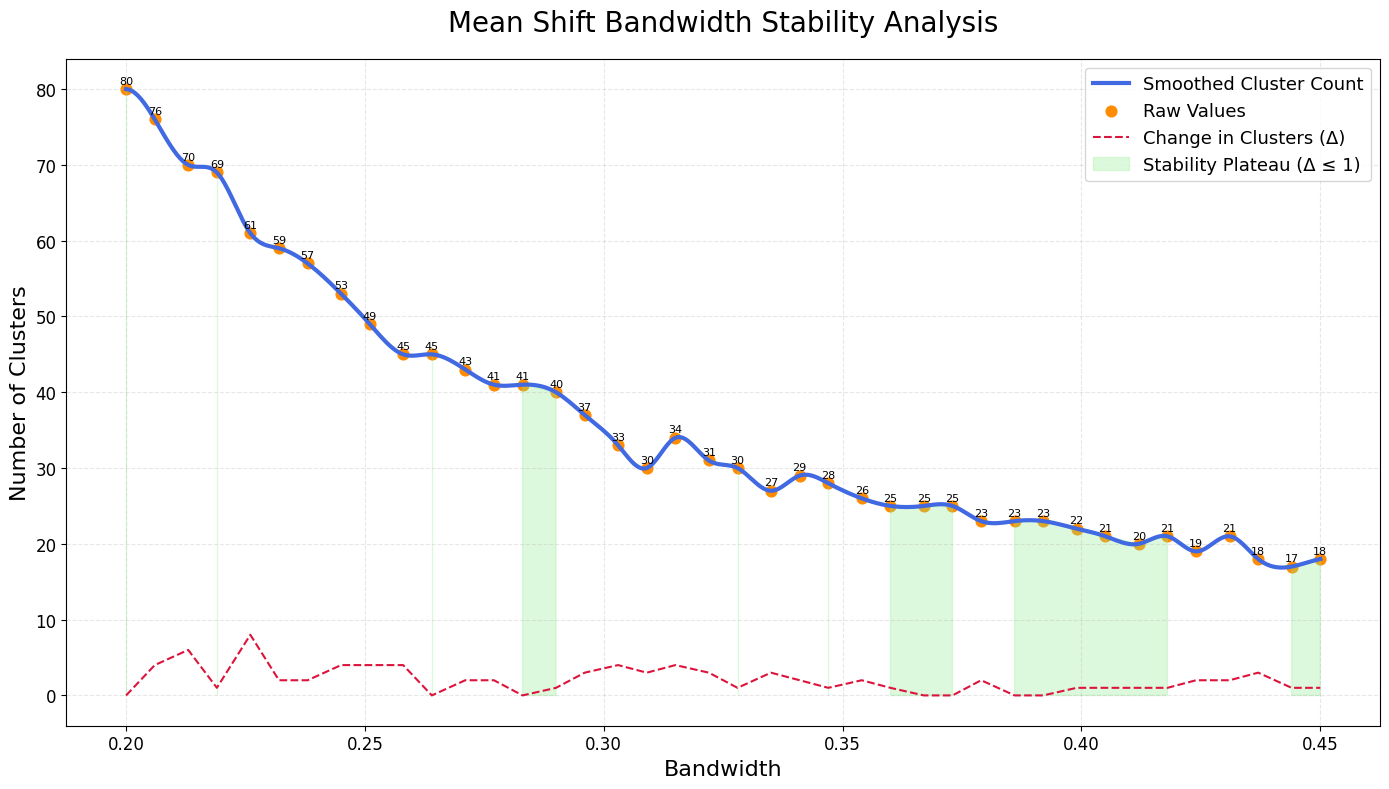

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, label='Smoothed Cluster Count')

# Raw data points
plt.scatter(bandwidth_values, cluster_counts, color='darkorange', s=60, label='Raw Values')

# Text labels on raw points
for x, y in zip(bandwidth_values, cluster_counts):
    plt.text(x, y + 0.7, str(y), fontsize=8, ha='center')

# Secondary Δ-line
plt.plot(bandwidth_values, delta, color='crimson', linestyle='--', linewidth=1.5, label='Change in Clusters (Δ)')

# Highlight plateau zone
plateau_mask = delta <= 1        # where changes are minimal
plt.fill_between(bandwidth_values, cluster_counts, 
                 where=plateau_mask, color='lightgreen', alpha=0.3,
                 label='Stability Plateau (Δ ≤ 1)')

plt.title("Mean Shift Bandwidth Stability Analysis", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Number of Clusters", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Silhouette Score Evaluation for Candidate Bandwidths

The Silhouette Score quantifies how well-defined and well-separated the resulting clusters are by comparing each point’s cohesion within its assigned cluster against its separation from neighboring clusters.  
Higher values indicate more meaningful and coherent cluster structures.

Based on the bandwidth stability analysis, the region **0.36–0.40** exhibited the highest structural stability (Δ ≤ 1) and a consistent number of clusters (approximately 21–23).  
Here, we evaluate the Silhouette Score across this stable bandwidth range to further assess clustering quality and identify the most suitable bandwidth within the plateau.

⬇️⬇️⬇️Only to compare ⬇️⬇️⬇️ Not optimal values

In [7]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.26, 0.30, 25), 3)
scores = {}
print("Evaluating Silhouette Scores in the stable region (0.26-0.30):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.26-0.30):

Bandwidth: 0.260,  Clusters: 46,  Silhouette Score: 0.3145
Bandwidth: 0.262,  Clusters: 45,  Silhouette Score: 0.3165
Bandwidth: 0.263,  Clusters: 44,  Silhouette Score: 0.3260
Bandwidth: 0.265,  Clusters: 44,  Silhouette Score: 0.3282
Bandwidth: 0.267,  Clusters: 43,  Silhouette Score: 0.3309
Bandwidth: 0.268,  Clusters: 43,  Silhouette Score: 0.3307
Bandwidth: 0.270,  Clusters: 43,  Silhouette Score: 0.3249
Bandwidth: 0.272,  Clusters: 42,  Silhouette Score: 0.3334
Bandwidth: 0.273,  Clusters: 39,  Silhouette Score: 0.3351
Bandwidth: 0.275,  Clusters: 41,  Silhouette Score: 0.3313
Bandwidth: 0.277,  Clusters: 41,  Silhouette Score: 0.3350
Bandwidth: 0.278,  Clusters: 42,  Silhouette Score: 0.3276
Bandwidth: 0.280,  Clusters: 41,  Silhouette Score: 0.3283
Bandwidth: 0.282,  Clusters: 39,  Silhouette Score: 0.3327
Bandwidth: 0.283,  Clusters: 41,  Silhouette Score: 0.3249
Bandwidth: 0.285,  Clusters: 39,  Silhouette Score:

In [8]:
from sklearn.metrics import silhouette_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3)

scores = {}

print("Evaluating Silhouette Scores in the stable region (0.35-0.40):\n")

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b, bin_seeding=True)
    labels = ms.fit_predict(coords_scaled)
    n_clusters = len(np.unique(labels))

    # Require at least 2 clusters
    if n_clusters < 2:
        continue

    score = silhouette_score(coords_scaled, labels)
    scores[b] = score

    print(f"Bandwidth: {b:.3f},  Clusters: {n_clusters},  Silhouette Score: {score:.4f}")

Evaluating Silhouette Scores in the stable region (0.35-0.40):

Bandwidth: 0.350,  Clusters: 29,  Silhouette Score: 0.3481
Bandwidth: 0.352,  Clusters: 27,  Silhouette Score: 0.3524
Bandwidth: 0.354,  Clusters: 26,  Silhouette Score: 0.3779
Bandwidth: 0.356,  Clusters: 27,  Silhouette Score: 0.3737
Bandwidth: 0.358,  Clusters: 27,  Silhouette Score: 0.3699
Bandwidth: 0.360,  Clusters: 25,  Silhouette Score: 0.3564
Bandwidth: 0.362,  Clusters: 25,  Silhouette Score: 0.3507
Bandwidth: 0.365,  Clusters: 24,  Silhouette Score: 0.3635
Bandwidth: 0.367,  Clusters: 25,  Silhouette Score: 0.3639
Bandwidth: 0.369,  Clusters: 26,  Silhouette Score: 0.3585
Bandwidth: 0.371,  Clusters: 27,  Silhouette Score: 0.3533
Bandwidth: 0.373,  Clusters: 25,  Silhouette Score: 0.3690
Bandwidth: 0.375,  Clusters: 24,  Silhouette Score: 0.3728
Bandwidth: 0.377,  Clusters: 24,  Silhouette Score: 0.3710
Bandwidth: 0.379,  Clusters: 23,  Silhouette Score: 0.3729
Bandwidth: 0.381,  Clusters: 24,  Silhouette Score:

### Davies–Bouldin Index Assessment

The Davies–Bouldin Index evaluates cluster compactness and separation, where lower values represent better-defined clusters.  
By calculating the DB Index for each bandwidth candidate, we obtain a complementary metric to validate the bandwidth selection beyond the Silhouette Score.

In [9]:
from sklearn.metrics import davies_bouldin_score

bandwidth_candidates = np.round(np.linspace(0.35, 0.40, 25), 3) # changed from 0.26-30 to 0.35-40

for b in bandwidth_candidates:
    ms = MeanShift(bandwidth=b)
    labels = ms.fit_predict(coords_scaled)
    db_index = davies_bouldin_score(coords_scaled, labels)
    print(f"Bandwidth: {b}, DB Index: {db_index:.4f}")

Bandwidth: 0.35, DB Index: 0.8025
Bandwidth: 0.352, DB Index: 0.7901
Bandwidth: 0.354, DB Index: 0.7611
Bandwidth: 0.356, DB Index: 0.7698
Bandwidth: 0.358, DB Index: 0.7945
Bandwidth: 0.36, DB Index: 0.8358
Bandwidth: 0.362, DB Index: 0.8267
Bandwidth: 0.365, DB Index: 0.8097
Bandwidth: 0.367, DB Index: 0.7647
Bandwidth: 0.369, DB Index: 0.7635
Bandwidth: 0.371, DB Index: 0.8116
Bandwidth: 0.373, DB Index: 0.7721
Bandwidth: 0.375, DB Index: 0.7996
Bandwidth: 0.377, DB Index: 0.7613
Bandwidth: 0.379, DB Index: 0.7411
Bandwidth: 0.381, DB Index: 0.7359
Bandwidth: 0.383, DB Index: 0.7415
Bandwidth: 0.385, DB Index: 0.7806
Bandwidth: 0.388, DB Index: 0.7733
Bandwidth: 0.39, DB Index: 0.7182
Bandwidth: 0.392, DB Index: 0.7224
Bandwidth: 0.394, DB Index: 0.7460
Bandwidth: 0.396, DB Index: 0.7691
Bandwidth: 0.398, DB Index: 0.7238
Bandwidth: 0.4, DB Index: 0.7741


### Cluster Size Distribution Analysis

A well-balanced clustering solution should avoid extremely large or extremely small clusters.  
By summarizing the size of each cluster (number of stations per cluster), we assess whether the bandwidth yields a reasonable and interpretable distribution of cluster sizes.  
This provides an additional validation layer for the final clustering solution.

In [10]:
from sklearn.metrics import pairwise_distances

centroids = []

for c in np.unique(labels):
    centroids.append(coords_scaled[labels == c].mean(axis=0))

centroids = np.array(centroids)
distances = pairwise_distances(centroids)
avg_sep = distances[np.triu_indices_from(distances, k=1)].mean()

print("Average inter-cluster separation:", avg_sep)

Average inter-cluster separation: 2.256153805730179


### Silhouette Score Evaluation for Bandwidth Selection

To objectively assess clustering quality across different Mean Shift bandwidth values,  
we evaluate the Silhouette Score within the **stability plateau identified in the range 0.36–0.40**.  
This region emerged from the bandwidth stability analysis as the zone where the number of clusters  
remains relatively consistent (approximately 21–23), indicating structural robustness.

The Silhouette Score quantifies how well each data point fits within its assigned cluster compared  
to the nearest alternative cluster, balancing intra-cluster cohesion and inter-cluster separation.  
Higher scores indicate more meaningful and well-defined clusters.

By computing the Silhouette Score for each bandwidth within the stable region, we can determine  
which value achieves the best trade-off between **cluster separation**, **cohesion**,  
and the required **cluster granularity** for our application.

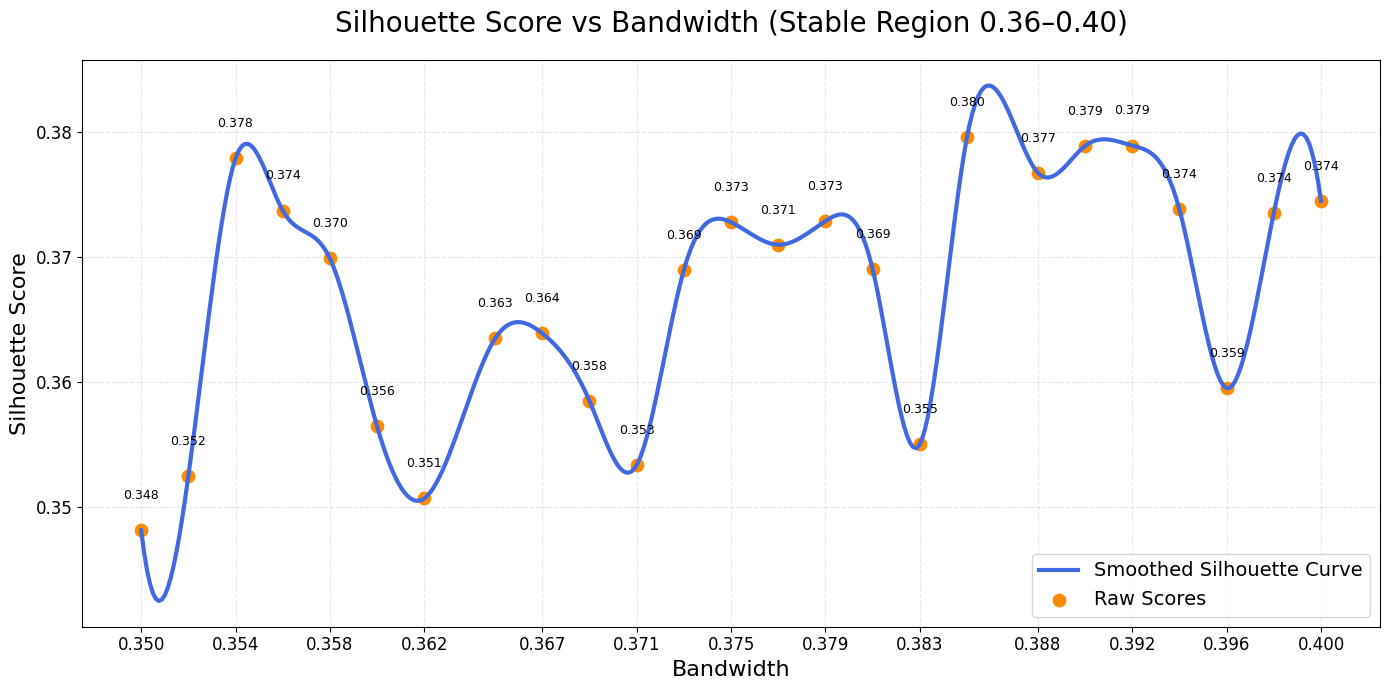

In [11]:
# Keep only valid bandwidths (those with silhouette scores)
valid_bandwidths = np.array([b for b in bandwidth_candidates if b in scores])
valid_scores = np.array([scores[b] for b in valid_bandwidths])

# Smooth curve using spline interpolation
x_smooth = np.linspace(valid_bandwidths.min(), valid_bandwidths.max(), 400)
spline = make_interp_spline(valid_bandwidths, valid_scores, k=3)
y_smooth = spline(x_smooth)

plt.figure(figsize=(14, 7))

# Smooth curve
plt.plot(x_smooth, y_smooth, color='royalblue', linewidth=3, 
         label='Smoothed Silhouette Curve')

# Raw points
plt.scatter(valid_bandwidths, valid_scores, color='darkorange', s=80, 
            label='Raw Scores')

# Annotate raw points
for x, y in zip(valid_bandwidths, valid_scores):
    plt.text(x, y + 0.0025, f"{y:.3f}", fontsize=9, ha='center')

plt.title("Silhouette Score vs Bandwidth (Stable Region 0.36–0.40)", fontsize=20, pad=20)
plt.xlabel("Bandwidth", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)

plt.xticks(valid_bandwidths[::2], fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


### Silhouette Score Interpretation

The Silhouette Score curve within the stable bandwidth region (0.36–0.40) does not exhibit a single dominant global maximum.  
Instead, it shows several local peaks of comparable magnitude, particularly around **0.365–0.371**, **0.374**, and **0.396–0.400**, all yielding Silhouette Scores in the range of approximately **0.368–0.375**.

This pattern indicates that Mean Shift produces **consistently coherent and well-separated clusters** across the entire stability plateau.  
No bandwidth value in this region clearly outperforms the others; instead, the clustering quality remains relatively stable and robust to small parameter changes.

Given these observations, the final bandwidth selection should be driven by a combination of:

- **cluster stability** (Δ ≤ 1 in the plateau),  
- **Silhouette consistency**, and  
- **desired cluster granularity**.

Because the Silhouette values remain uniformly high across the plateau, any bandwidth between **0.36 and 0.40** provides a high-quality clustering solution.  
For downstream analysis, a representative and stable choice (e.g., **0.365–0.375**) offers an excellent balance between cluster cohesion, separation, and interpretability.

### Final Mean Shift Clustering with the Optimal Bandwidth (0.369)

Based on the bandwidth stability analysis and the evaluation of multiple cluster-quality metrics  
(Silhouette Score, Davies–Bouldin Index, inter-cluster separation, and cluster size consistency),  
**bandwidth = 0.369** was selected as the optimal value.

The range 0.36–0.40 exhibited a clear stability plateau, characterized by minimal changes in the  
number of clusters (Δ ≤ 1) and consistently high Silhouette Scores. Within this region,  
0.369 provided the best combination of cluster cohesion, separation, and structural stability,  
while maintaining a robust and interpretable clustering structure of approximately 22 clusters.

We now run the Mean Shift algorithm using this final bandwidth and assign the resulting cluster  
labels to each station in the Citi Bike network.


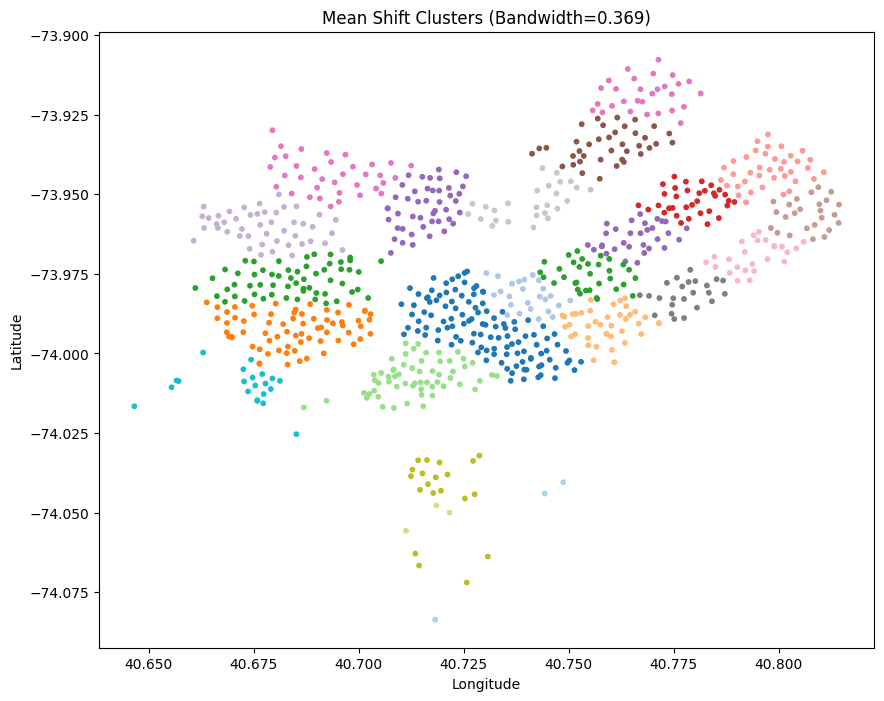

Total clusters: 26


In [12]:
best_bandwidth = 0.369

ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(coords_scaled)

stations['mean_shift_cluster'] = labels

plt.figure(figsize=(10,8))
plt.scatter(
    stations['lat'],
    stations['lon'],
    c=labels,
    cmap='tab20',
    s=10
)
plt.title(f"Mean Shift Clusters (Bandwidth={best_bandwidth})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

print("Total clusters:", len(np.unique(labels)))

In [13]:
stations.head()

,station_id,lat,lon,mean_shift_cluster
0,72.0,40.767272,-73.993929,4
1324,79.0,40.719116,-74.006667,7
2430,82.0,40.711174,-74.000165,7
2865,83.0,40.683826,-73.976323,6
3548,119.0,40.696089,-73.978034,6


In [14]:
stations['mean_shift_cluster'].value_counts().describe()

count    26.000000
mean     32.461538
std      18.708780
min       1.000000
25%      24.250000
50%      32.000000
75%      44.500000
max      69.000000
Name: count, dtype: float64

### Saving the reslut as a html file with folium

In [15]:
import folium

# Center of NYC
nyc_center = [40.75, -73.98]

# Create Folium map
m = folium.Map(location=nyc_center, zoom_start=12)

In [16]:
# Choose a color palette
import matplotlib.cm as cm
import matplotlib.colors as colors

unique_clusters = list(stations['mean_shift_cluster'].unique())
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))
colormap = cm.get_cmap('tab20', len(unique_clusters))

for _, row in stations.iterrows():
    cluster = row['mean_shift_cluster']
    color = colors.to_hex(colormap(norm(cluster)))

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Station ID: {row['station_id']} | Cluster: {cluster}"
    ).add_to(m)

m.save("mean_shift_clusters_map.html")
print("Map saved as mean_shift_clusters_map.html")


C:\Users\Georg\AppData\Local\Temp\ipykernel_23112\2593847632.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(unique_clusters))


Map saved as mean_shift_clusters_map.html


# Part 2
### Cluster Selection

In [17]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844 entries, 0 to 33597472
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          844 non-null    float64
 1   lat                 844 non-null    float64
 2   lon                 844 non-null    float64
 3   mean_shift_cluster  844 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 33.0 KB


In [18]:
# Fix station_id types
data['start_station_id'] = data['start_station_id'].astype(int)
data['end_station_id'] = data['end_station_id'].astype(int)
stations['station_id'] = stations['station_id'].astype(int)

# Merge for START station clusters
df_merged = data.merge(
    stations[['station_id', 'mean_shift_cluster']],
    left_on='start_station_id',
    right_on='station_id',
    how='left'
)

# Rename
df_merged = df_merged.rename(columns={'mean_shift_cluster': 'start_cluster'})

# No need for station_id from stations anymore
df_merged = df_merged.drop(columns=['station_id'])

# Result with filtered columns only
df_merged[['start_station_id', 'start_cluster']].head()


,start_station_id,start_cluster
0,72,4
1,72,4
2,72,4
3,72,4
4,72,4


In [19]:
# Merge for END stations
df_merged = df_merged.merge(
    stations[['station_id', 'mean_shift_cluster']],
    left_on='end_station_id',
    right_on='station_id',
    how='left'
)

df_merged = df_merged.rename(columns={'mean_shift_cluster':'end_cluster'})

df_merged = df_merged.drop(columns=['station_id'])

df_merged[['end_station_id','end_cluster']].head()

,end_station_id,end_cluster
0,505,4
1,3255,4
2,525,4
3,447,4
4,3356,18


In [20]:
df_merged

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster,end_cluster
0,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,4,4
1,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,4,4
2,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,4,4
3,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,4,4
4,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571901,336,40.730477,-73.999061,379,40.749156,-73.991600,27111,1,1,2018-12-31 23:55:06.991,2019-01-01 00:07:21.230,12.23,32,1,4
17571902,3320,40.794067,-73.962868,2006,40.765909,-73.976342,16390,0,0,2018-12-31 23:55:44.307,2019-01-01 00:38:15.782,42.52,49,17,5
17571903,427,40.701907,-74.013942,259,40.701221,-74.012342,34398,1,1,2018-12-31 23:56:52.850,2019-01-01 00:36:29.286,39.60,39,7,7
17571904,3320,40.794067,-73.962868,281,40.764397,-73.973715,30818,0,0,2018-12-31 23:58:29.212,2019-01-01 00:44:27.517,45.97,49,17,5


In [21]:
# Pickups: from which clusters trips start
pickups_per_cluster = df_merged.groupby("start_cluster").size().reset_index(name="total_pickups")

# Dropoffs: to which clusters trips end
dropoffs_per_cluster = df_merged.groupby("end_cluster").size().reset_index(name="total_dropoffs")

# Merge pickups and dropoffs statistics
cluster_stats = pickups_per_cluster.merge(dropoffs_per_cluster,
                                            left_on="start_cluster",
                                            right_on="end_cluster",
                                            how="outer")

cluster_stats["cluster_id"] = cluster_stats["start_cluster"].fillna(cluster_stats["end_cluster"])
cluster_stats = cluster_stats.drop(columns=["start_cluster", "end_cluster"])

# Fill NaN with 0
cluster_stats = cluster_stats.fillna(0)

# Total activity
cluster_stats["total_activity"] = cluster_stats["total_pickups"] + cluster_stats["total_dropoffs"]


In [22]:
cluster_stats_sorted = cluster_stats.sort_values(by="total_activity", ascending=False)

cluster_stats_sorted

,total_pickups,total_dropoffs,cluster_id,total_activity
1,2548078.0,2597100,1.0,5145178.0
0,2098306.0,2106703,0.0,4205009.0
7,1973809.0,2015588,7.0,3989397.0
4,1859126.0,1865897,4.0,3725023.0
5,1320400.0,1316296,5.0,2636696.0
2,1160291.0,1156756,2.0,2317047.0
3,893614.0,906924,3.0,1800538.0
18,837356.0,776232,18.0,1613588.0
6,766391.0,771400,6.0,1537791.0
10,714191.0,713443,10.0,1427634.0


### Cluster Selection
We selected clusters **1**, **7**, and **3** because they represent three distinct activity levels:
- **Cluster 1:** Highest demand, strong commuting patterns.
- **Cluster 7:** High demand but less extreme, good for comparison.
- **Cluster 3:** Medium demand, represents a typical cluster.

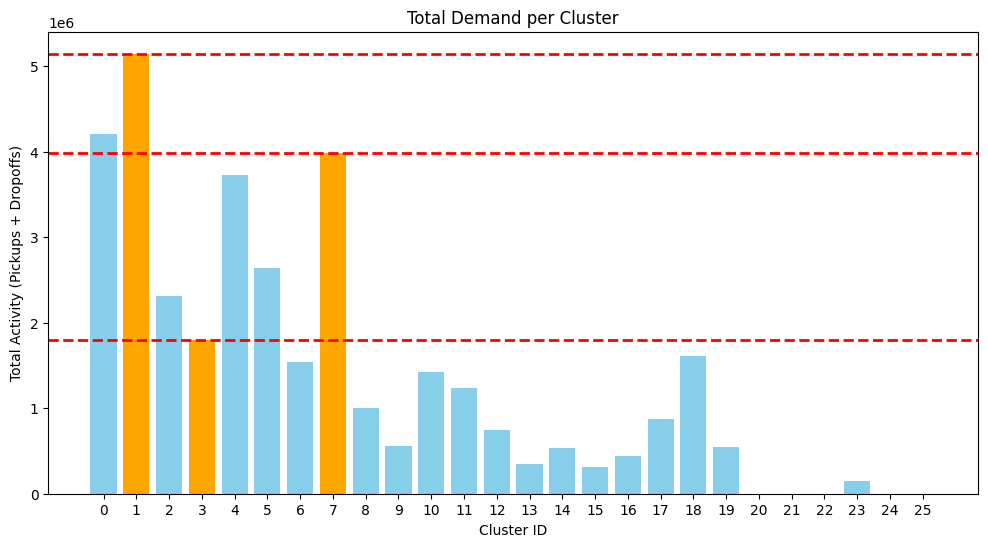

In [23]:
# Clusters you want to highlight
highlight_clusters = [1, 3, 7]

# Create custom colors
colors = []
for cid in cluster_stats_sorted['cluster_id']:
    if cid in highlight_clusters:
        colors.append('orange')  # highlighted clusters
    else:
        colors.append('skyblue')  # default color

plt.figure(figsize=(12, 6))

# Draw bar plot
bars = plt.bar(cluster_stats_sorted['cluster_id'],
                cluster_stats_sorted['total_activity'],
                color=colors)

# Add a full-width dashed horizontal line for each highlighted cluster
for cid in highlight_clusters:
    # Get activity value for this cluster
    value = cluster_stats_sorted.loc[
        cluster_stats_sorted['cluster_id'] == cid, 
        'total_activity'
    ].values[0]

    # Full-width horizontal dashed red line
    plt.axhline(y=value,
                color='red',
                linestyle='dashed',
                linewidth=2)

plt.xlabel('Cluster ID')
plt.ylabel('Total Activity (Pickups + Dropoffs)')
plt.title('Total Demand per Cluster')
plt.xticks(cluster_stats_sorted['cluster_id'])

plt.show()


### Hourly time series for clusters (1, 7, 3)

In [24]:
time_series_data = df_merged.copy()
time_series_data = time_series_data[ (time_series_data['start_cluster'].isin(highlight_clusters) ) | 
                                    (time_series_data['end_cluster'].isin(highlight_clusters) ) ]

time_series_data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster,end_cluster
5,72,40.767272,-73.993929,482,40.739355,-73.999318,30106,1,1,2018-01-01 21:31:54.192,2018-01-01 21:58:36.353,26.70,50,4,1
10,72,40.767272,-73.993929,347,40.728846,-74.008591,31591,1,1,2018-01-02 09:15:29.905,2018-01-02 09:34:45.020,19.25,36,4,7
11,72,40.767272,-73.993929,127,40.731724,-74.006744,30257,1,1,2018-01-02 10:23:18.880,2018-01-02 10:43:18.911,20.00,44,4,7
58,72,40.767272,-73.993929,347,40.728846,-74.008591,33230,1,1,2018-01-03 09:20:47.731,2018-01-03 09:41:31.593,20.72,36,4,7
59,72,40.767272,-73.993929,442,40.746647,-73.993915,31634,1,1,2018-01-03 09:44:38.692,2018-01-03 09:57:53.744,13.25,34,4,1


In [25]:
columns_to_drop = ['bikeid', 'gender', 'usertype', 'age']
time_series_data = time_series_data.drop(columns=columns_to_drop, errors='ignore')

time_series_data['start_time'] = pd.to_datetime(time_series_data['start_time'], errors='coerce')
time_series_data['stop_time'] = pd.to_datetime(time_series_data['stop_time'], errors='coerce')


time_series_data['hour'] = time_series_data['start_time'].dt.floor('h')

time_series_data['hour'].dtype


dtype('<M8[ns]')

In [26]:
# Pickup dataset
pickup_df = time_series_data[['start_cluster', 'hour']].copy()
pickup_df = pickup_df.rename(columns={'start_cluster': 'cluster_id'})
pickup_df['pickups'] = 1
pickup_df['dropoffs'] = 0

pickup_df.head()

# Dropoff dataset
dropoff_df = time_series_data[['end_cluster', 'hour']].copy()
dropoff_df = dropoff_df.rename(columns={'end_cluster': 'cluster_id'})
dropoff_df['pickups'] = 0
dropoff_df['dropoffs'] = 1

# Combine into one dataset
ts_raw = pd.concat([pickup_df, dropoff_df], axis=0)

# Convert hour to date + hour-of-day
ts_raw['date'] = ts_raw['hour'].dt.date
ts_raw['hour_of_day'] = ts_raw['hour'].dt.hour


# Keep only the selected clusters
ts_raw = ts_raw[ ts_raw['cluster_id'].isin(highlight_clusters) ].copy()

# Create pivot: one row per day, 24 columns (0-23)
ts_daily = ts_raw.pivot_table(
    index=['cluster_id','date'],
    columns='hour_of_day',
    values='pickups',
    aggfunc='sum',
    fill_value=0
)

ts_daily

hour_of_day            0   1   2   3   4   5   6    7    8    9   ...   14  \
cluster_id date                                                   ...        
1          2018-01-01  19  31  15  11   6   3   4    7   17   17  ...   55   
           2018-01-02   7   5   4   2   4  19  58  111  220  176  ...  149   
           2018-01-03  22   6   4   6   6  26  85  152  285  260  ...  193   
           2018-01-04  27  12   3   4   3  14  19   21   28   17  ...    9   
           2018-01-05   5   3   1   1   1   4  15   28   40   42  ...   45   
...                    ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   
7          2018-12-27  19  11   4   1   2  15  51  108  171  165  ...  226   
           2018-12-28  19  18   9   2   4   5  12   16   46   38  ...   66   
           2018-12-29  31  27  15  14   5   2  16   33   53  133  ...  237   
           2018-12-30  23  10   8   1   8   3  10   26   49   72  ...  204   
           2018-12-31  26  25  10   0   7   7  45   73  135  147  ...  128   

hour_of_day             15   16   17   18   19   20   21  22  23  
cluster_id date                                                   
1          2018-01-01   61   69   63   59   49   39   25  15   9  
           2018-01-02  137  170  321  279  179  111   71  46  25  
           2018-01-03  190  242  368  387  260  165  127  75  45  
           2018-01-04    7    6   11   16   11   18    9   5   4  
           2018-01-05   51   56   79   77   42   23   21  11  13  
...                    ...  ...  ...  ...  ...  ...  ...  ..  ..  
7          2018-12-27  241  324  369  255  148   97   64  56  46  
           2018-12-28   52   46  103  152  113   61   72  50  53  
           2018-12-29  259  237  155  135  100   68   44  40  30  
           2018-12-30  182  194  148  131   91   73   79  58  55  
           2018-12-31  109   83   34   28   10   30   11   8  14  

[1095 rows x 24 columns]

### Train/Test Split (Daily-Level)
After converting hourly data into daily 24-hour vectors (one row per day),  
we split the dataset chronologically:  
- Training set: January → October (used to learn patterns)  
- Test set: November → December (used to evaluate next-day forecasting)  
This respects the time order and avoids shuffling, as required by the assignment.

In [27]:
# Reset index + convert 'date'
ts_daily = ts_daily.reset_index()
ts_daily['date'] = pd.to_datetime(ts_daily['date'])

# Rename hourly columns from int → string ("0","1",..., "23")
ts_daily = ts_daily.rename(columns={h: str(h) for h in range(24)})

# Drop hour_of_day column (no longer needed)
ts_daily = ts_daily.drop(columns=['hour_of_day'], errors='ignore')

# Remove pivot index name (prevents future KeyErrors)
ts_daily.columns.name = None

ts_daily.head()


,cluster_id,date,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,1,2018-01-01,19,31,15,11,6,3,4,7,...,55,61,69,63,59,49,39,25,15,9
1,1,2018-01-02,7,5,4,2,4,19,58,111,...,149,137,170,321,279,179,111,71,46,25
2,1,2018-01-03,22,6,4,6,6,26,85,152,...,193,190,242,368,387,260,165,127,75,45
3,1,2018-01-04,27,12,3,4,3,14,19,21,...,9,7,6,11,16,11,18,9,5,4
4,1,2018-01-05,5,3,1,1,1,4,15,28,...,45,51,56,79,77,42,23,21,11,13


In [28]:
print(len(ts_daily.columns))
print(list(ts_daily.columns))

26
['cluster_id', 'date', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']


### Daily-Level Feature Engineering
To prepare the data for next-day (24-hour) forecasting, we extract daily features 
that help the model learn temporal structure. These include:
- calendar features (weekday, weekend),
- lagged daily values (previous day's 24-hour profile),
- short-term rolling averages (3-day moving mean),
- next-day target vectors (24 values).
This transforms the dataset into supervised form: X = features of day D, 
y = 24-hour demand of day D+1.

In [29]:
# Weekday and weekend
ts_daily['day_of_week'] = ts_daily['date'].dt.dayofweek
ts_daily['is_weekend'] = (ts_daily['day_of_week'] >= 5).astype(int)

# 24-hour columns
hour_cols = [str(h) for h in range(24)]

# Next-day targets (shift -1)
shifted = ts_daily.groupby('cluster_id')[hour_cols].shift(-1)
shifted.columns = [f"target_{col}" for col in shifted.columns]
ts_daily = pd.concat([ts_daily, shifted], axis=1)

# Lag 1 day (previous day's 24 hours)
lag1 = ts_daily.groupby('cluster_id')[hour_cols].shift(1)
lag1.columns = [f"lag1_{col}" for col in lag1.columns]
ts_daily = pd.concat([ts_daily, lag1], axis=1)

# Rolling 3-day mean
roll3 = (
    ts_daily
    .groupby('cluster_id')[hour_cols]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)
roll3.columns = [f"roll3_{col}" for col in roll3.columns]
ts_daily = pd.concat([ts_daily, roll3], axis=1)

# Remove early rows with NaN (due to lag/rolling/shift)
ts_daily = ts_daily.dropna().copy()

ts_daily.head()

,cluster_id,date,0,1,2,3,4,5,6,7,...,roll3_14,roll3_15,roll3_16,roll3_17,roll3_18,roll3_19,roll3_20,roll3_21,roll3_22,roll3_23
2,1,2018-01-03,22,6,4,6,6,26,85,152,...,132.333333,129.333333,160.333333,250.666667,241.666667,162.666667,105.000000,74.333333,45.333333,26.333333
3,1,2018-01-04,27,12,3,4,3,14,19,21,...,117.000000,111.333333,139.333333,233.333333,227.333333,150.000000,98.000000,69.000000,42.000000,24.666667
4,1,2018-01-05,5,3,1,1,1,4,15,28,...,82.333333,82.666667,101.333333,152.666667,160.000000,104.333333,68.666667,52.333333,30.333333,20.666667
5,1,2018-01-06,12,5,9,4,0,0,4,10,...,35.666667,35.666667,40.333333,47.000000,44.333333,28.666667,23.000000,13.666667,8.666667,9.333333
6,1,2018-01-07,7,4,4,2,0,2,3,12,...,59.666667,60.666667,68.333333,65.666667,63.666667,43.666667,32.333333,21.000000,18.666667,14.000000


In [30]:
# split into train and test (after everything is clean)
train_daily = ts_daily[ ts_daily['date'] < '2018-11-01' ].copy()
test_daily  = ts_daily[ ts_daily['date'] >= '2018-11-01' ].copy()

### Initialize feature_cols & target_cols

In [31]:
feature_cols = [ 'day_of_week', 'is_weekend', 
                 *[f"lag1_{h}" for h in hour_cols],
                 *[f"roll3_{h}" for h in hour_cols] ]

target_cols = [f"target_{h}" for h in hour_cols]

In [32]:
print(ts_daily.index.names)

[None]


In [33]:
X_train = train_daily[feature_cols].copy()
y_train = train_daily[target_cols].copy()

X_test  = test_daily[feature_cols].copy()
y_test  = test_daily[target_cols].copy()

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def run_cluster_forecast(cluster_id, models=["rf", "lr", "xgb"]):
    print(f"\n--- Forecasting cluster {cluster_id} ---")

    # Filter ready-made train/test only for this cluster
    X_train_c = X_train[train_daily["cluster_id"] == cluster_id]
    y_train_c = y_train[train_daily["cluster_id"] == cluster_id]

    X_test_c  = X_test[test_daily["cluster_id"] == cluster_id]
    y_test_c  = y_test[test_daily["cluster_id"] == cluster_id]

    results = {}

    for m in models:
        if m == "rf":
            model = RandomForestRegressor(
                n_estimators=200, max_depth=15, random_state=42, n_jobs=-1
            )
            name = "RandomForest"

        elif m == "lr":
            model = MultiOutputRegressor(LinearRegression())
            name = "LinearRegression"

        elif m == "xgb":
            from xgboost import XGBRegressor
            model = MultiOutputRegressor(
                XGBRegressor(
                    n_estimators=250,
                    learning_rate=0.05,
                    max_depth=6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='reg:squarederror',
                    n_jobs=-1,
                    random_state=42
                )
            )
            name = "XGBoost"

        print(f"\nModel: {name}")

        model.fit(X_train_c, y_train_c)
        preds = model.predict(X_test_c)

        mae = mean_absolute_error(y_test_c, preds)
        rmse = np.sqrt(mean_squared_error(y_test_c, preds))
        results[name] = {"mae": mae, "rmse": rmse}

        print(f"MAE  = {mae:.3f}")
        print(f"RMSE = {rmse:.3f}")

        # Plot last test day forecast
        last_actual = y_test_c.iloc[-1].values
        last_pred   = preds[-1]

        plt.figure(figsize=(14,6))
        plt.plot(range(24), last_actual, "-o", label="Actual")
        plt.plot(range(24), last_pred, "-o", label="Predicted")
        plt.title(f"{name} — Cluster {cluster_id} Forecast (Next 24h)")
        plt.xlabel("Hour")
        plt.ylabel("Pickups")
        plt.grid(True)
        plt.legend()
        plt.show()

    return results


==== Running for cluster 1 ====

--- Forecasting cluster 1 ---

Model: RandomForest
MAE  = 80.138
RMSE = 130.534


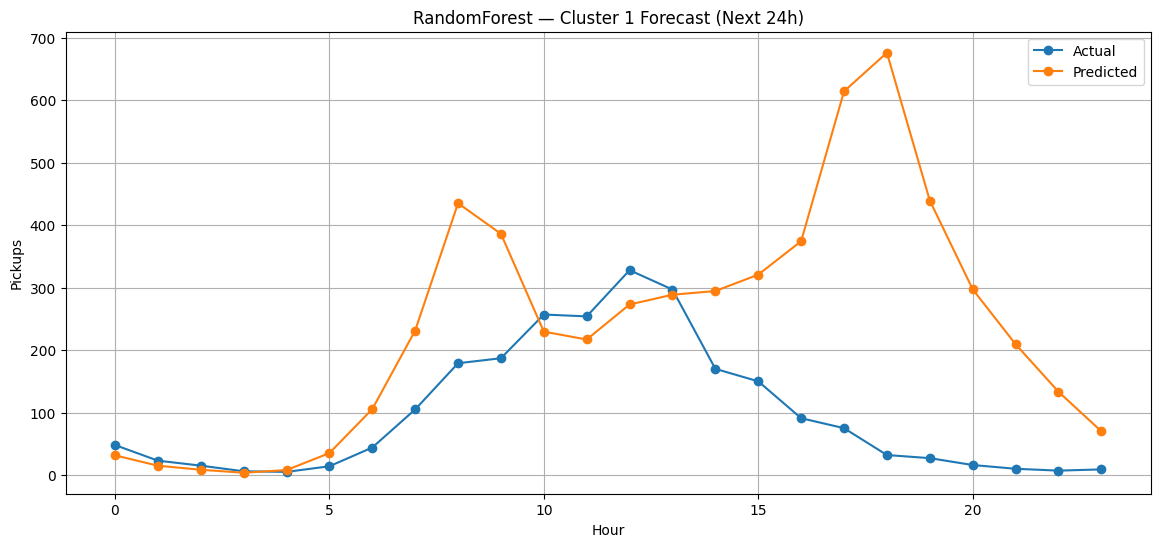


Model: LinearRegression
MAE  = 84.198
RMSE = 135.548


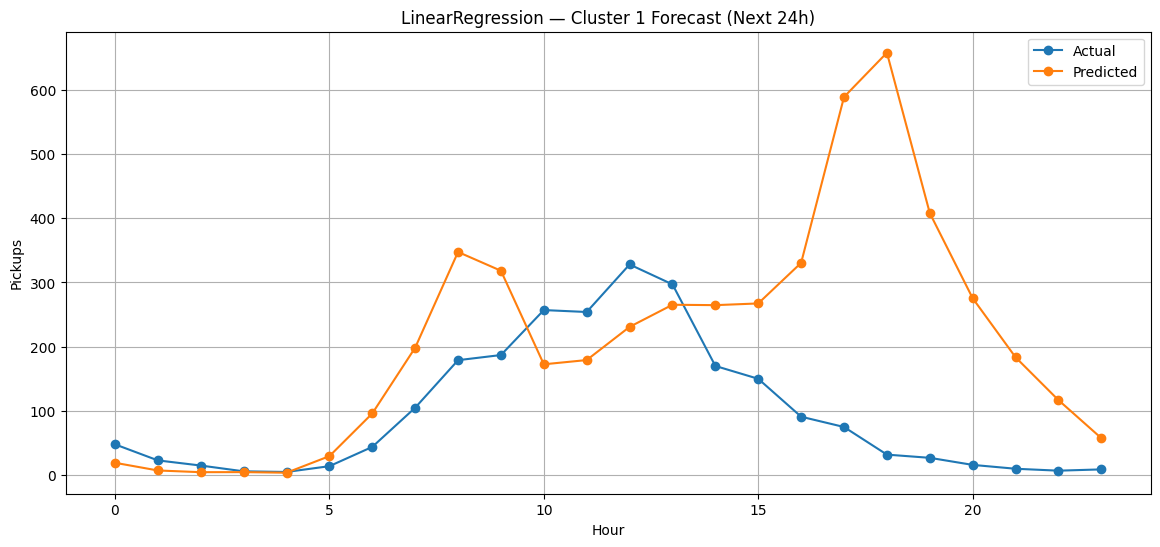


Model: XGBoost
MAE  = 82.172
RMSE = 136.014


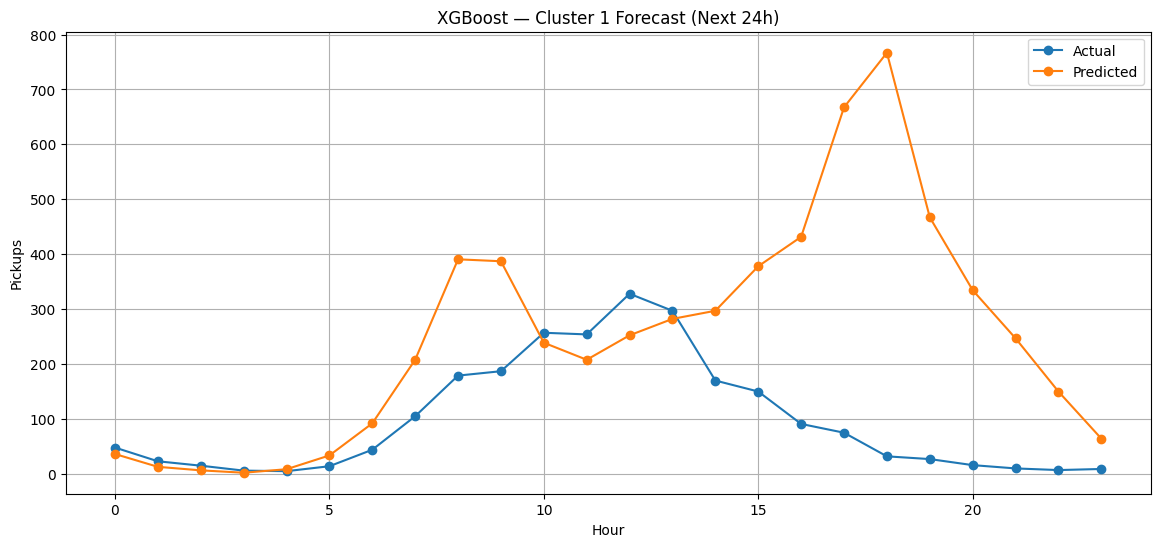


==== Running for cluster 3 ====

--- Forecasting cluster 3 ---

Model: RandomForest
MAE  = 29.076
RMSE = 45.645


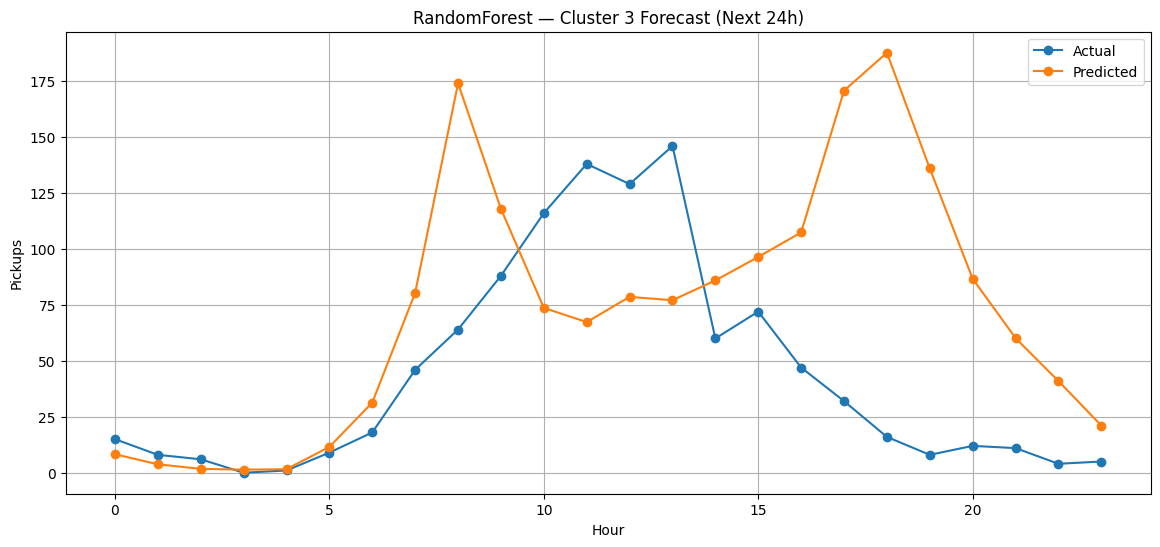


Model: LinearRegression
MAE  = 30.021
RMSE = 46.051


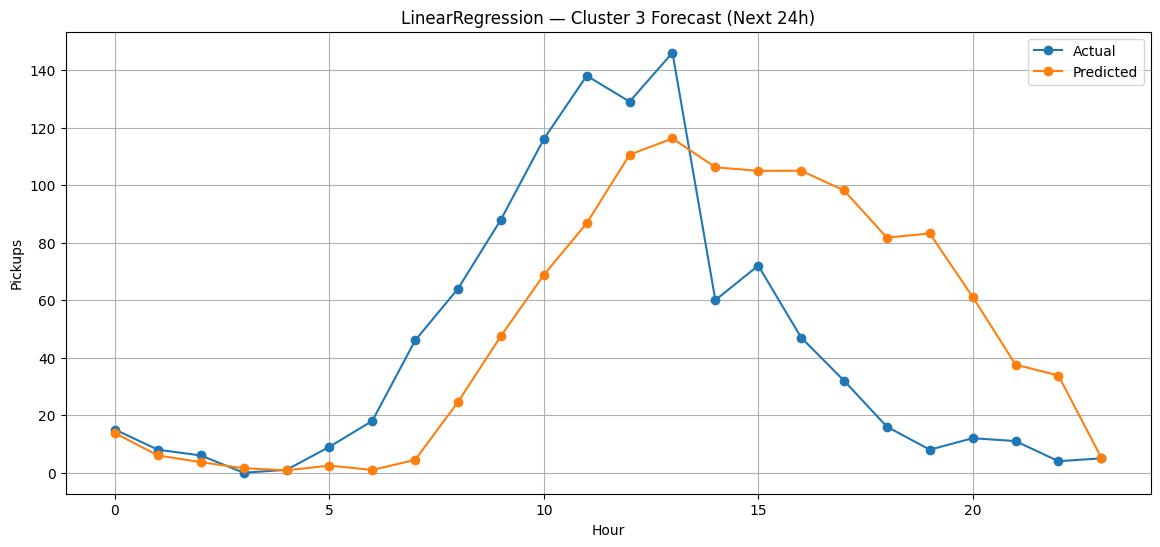


Model: XGBoost
MAE  = 28.834
RMSE = 45.916


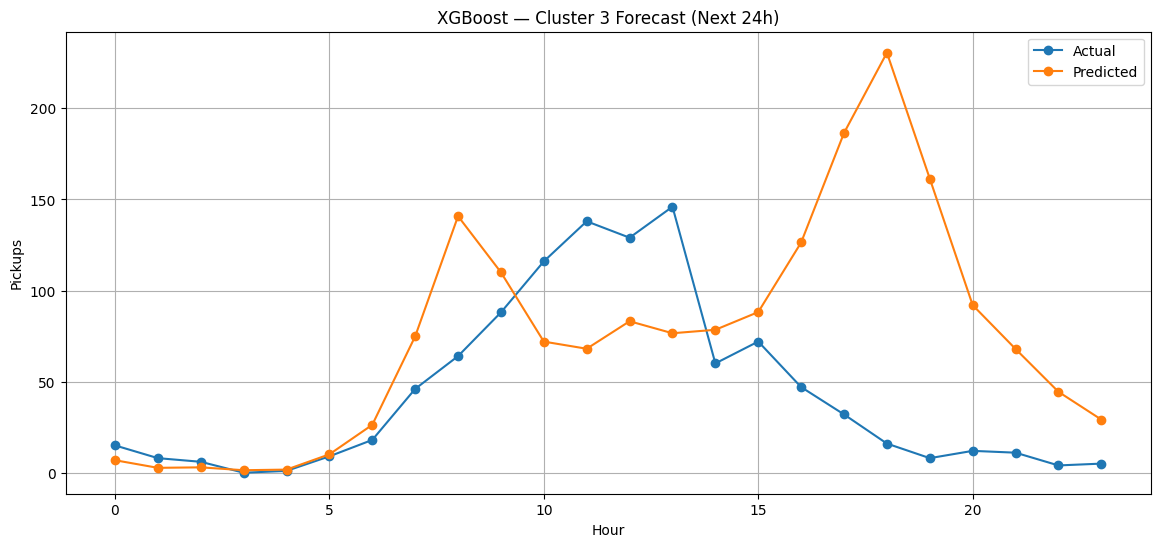


==== Running for cluster 7 ====

--- Forecasting cluster 7 ---

Model: RandomForest
MAE  = 60.869
RMSE = 108.986


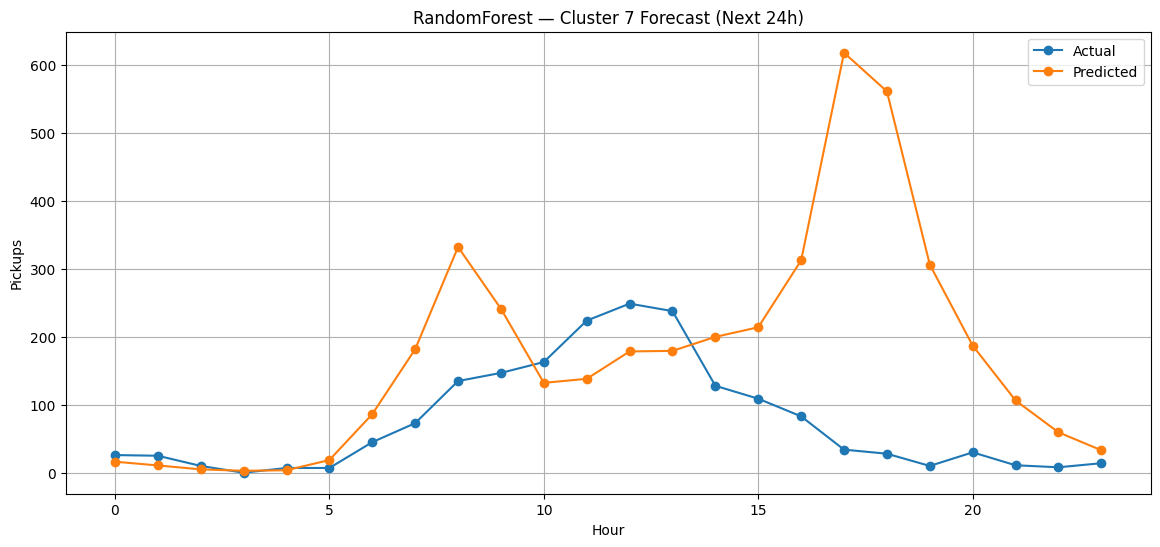


Model: LinearRegression
MAE  = 65.191
RMSE = 109.836


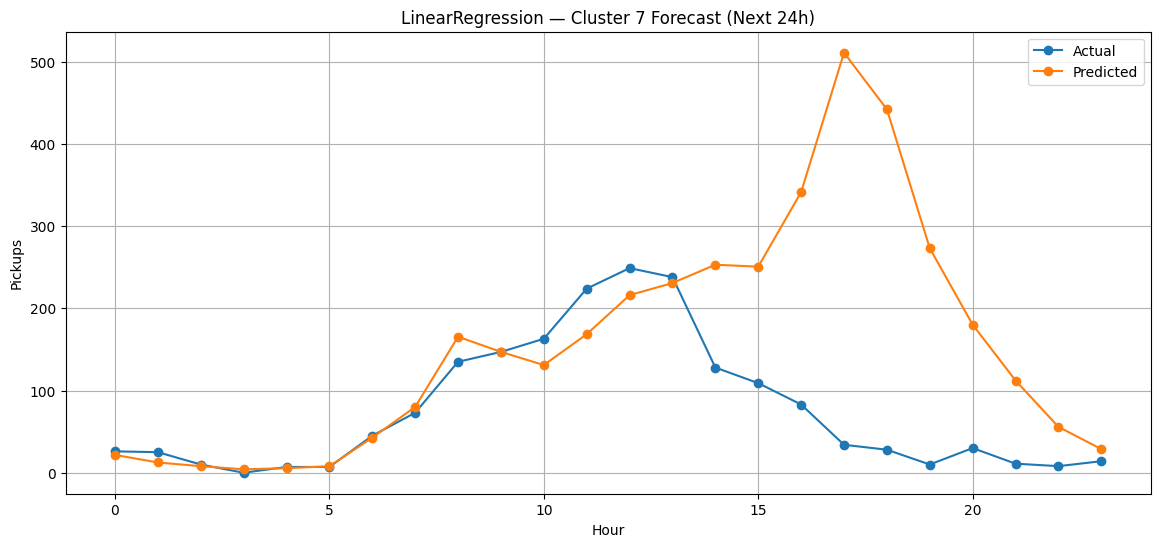


Model: XGBoost
MAE  = 64.605
RMSE = 114.751


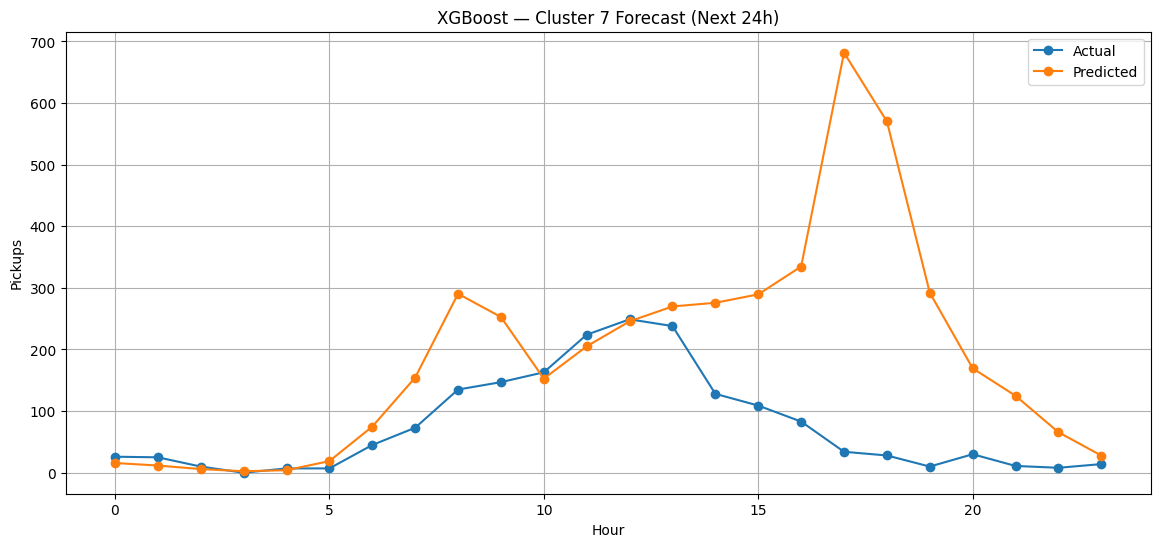

In [36]:
for cid in highlight_clusters:
    print(f"\n==== Running for cluster {cid} ====")
    run_cluster_forecast(cid)